In [ ]:
#!pip install -q tensorflow-gpu==2.0.0-beta0
#!pip install torch==1.3.0


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# import sys
# sys.path.insert(0, '/content/drive/')
# os.chdir("/content/drive/")
# print(os.getcwd())
# print(os.listdir())

In [ ]:
import sys
sys.path.insert(0, '/content/drive/My Drive/')

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

data_dir = "/drive/My Drive/spiders_new/"
os.chdir("/content/drive/My Drive/spiders2_new_dataset/")
#os.chdir("/content/drive/My Drive/spiders_new/")
print(os.getcwd())


/content/drive/My Drive/spiders2_new_dataset


In [ ]:
# necessary imports
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms

print(os.getcwd())

/content/drive/My Drive/spiders2_new_dataset


In [ ]:
def get_dataloader(batch_size, image_size, data_dir=os.getcwd()):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    print("hey man")
    print(data_dir)
    dataset = dset.ImageFolder(root=data_dir,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)
    return dataloader

In [ ]:
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

# Define function hyperparameters
batch_size = 32
img_size = 64

In [ ]:
# Call your function and get a dataloader
spiders_train_loader = get_dataloader(batch_size, img_size)

hey man
/content/drive/My Drive/spiders2_new_dataset


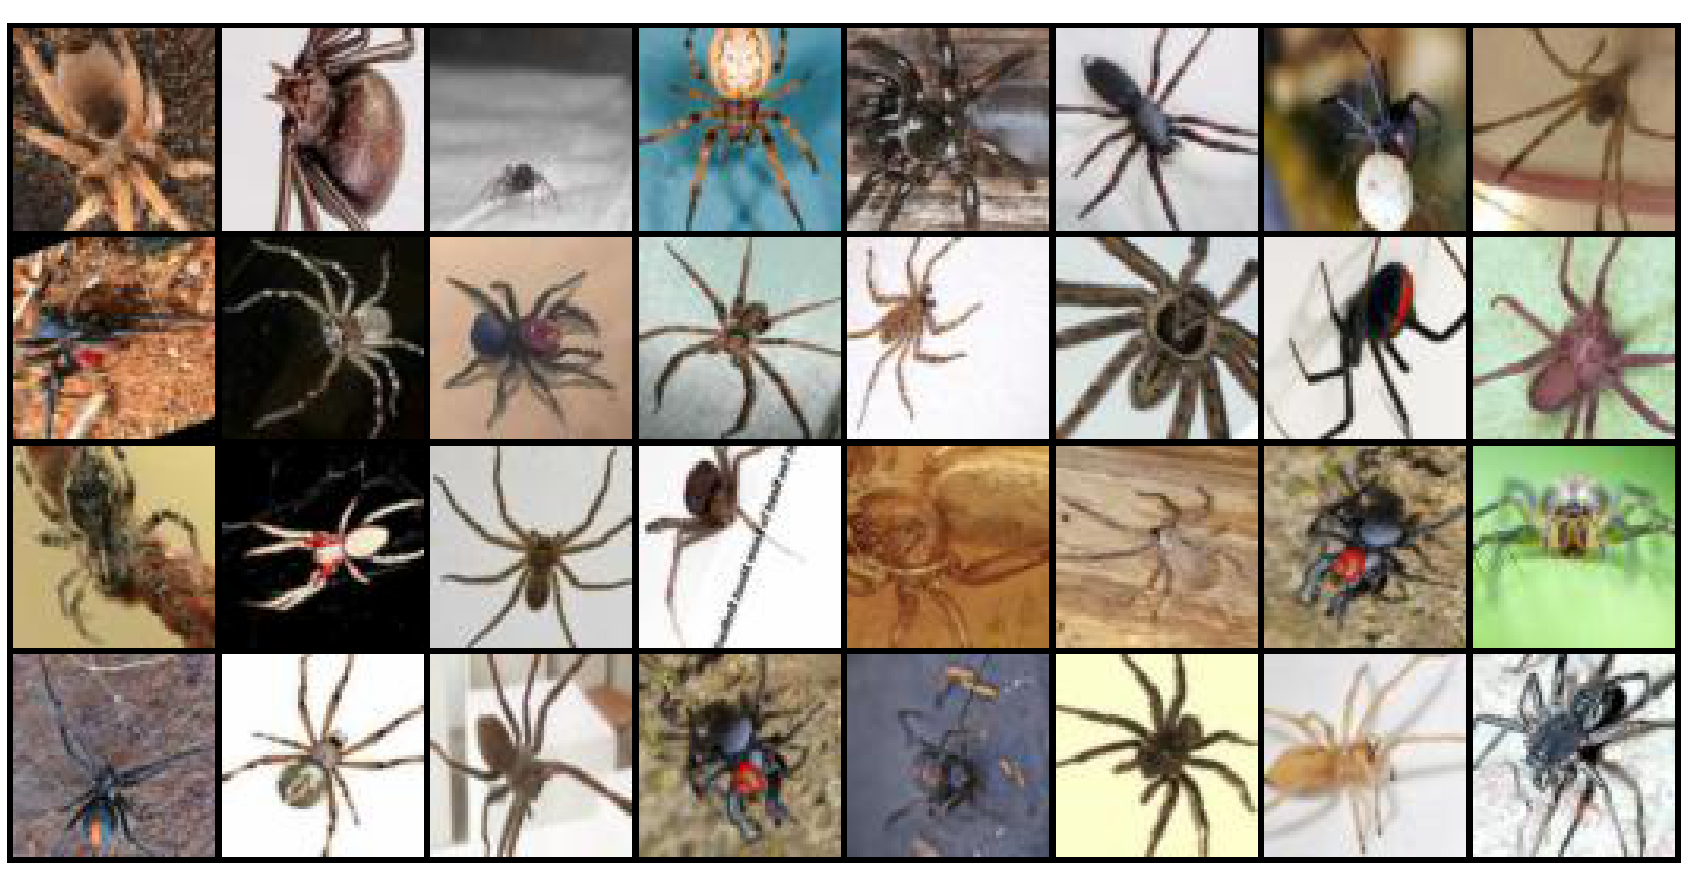

In [ ]:
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(spiders_train_loader))
plt.figure(figsize=(30,30))
plt.axis("off")
plt.title("Training Images", color='white')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=64, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv_dim = conv_dim
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, conv_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. conv_dim x 32 x 32
            nn.Conv2d(conv_dim, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (conv_dim*2) x 16 x 16
            nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (conv_dim*4) x 8 x 8
            nn.Conv2d(conv_dim * 4, conv_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (conv_dim*8) x 4 x 4
            nn.Conv2d(conv_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(d_conv_dim, ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=64, ngpu=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.conv_dim = conv_dim
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_size, conv_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( conv_dim * 4, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(conv_dim * 2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(z_size, g_conv_dim, ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0
lr = 0.0002
beta1=0.5

#====================================================================================================================
#                             1 Optimizer: Adam.
#====================================================================================================================
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

#====================================================================================================================
#                             2 Optimizer: ASGD.
#====================================================================================================================
# # Setup ASGD optimizers for both G and D
# optimizerD = optim.ASGD(netD.parameters(), lr=lr)
# optimizerG = optim.ASGD(netG.parameters(), lr=lr)

#====================================================================================================================
#                             3 Optimizer: RMSprop.
#====================================================================================================================
# # Setup RMSprop optimizers for both G and D
# optimizerD = optim.RMSprop(netD.parameters(), lr=lr, alpha=beta1)
# optimizerG = optim.RMSprop(netG.parameters(), lr=lr, alpha=beta1)

#====================================================================================================================
#                             4 Optimizer: SGD.
#====================================================================================================================
# # Setup SGD optimizers for both G and D
# optimizerD = optim.SGD(netD.parameters(), lr=lr)
# optimizerG = optim.SGD(netG.parameters(), lr=lr)

#====================================================================================================================
#                             5 Optimizer: Rprop.
#====================================================================================================================
# # Setup Rprop optimizers for both G and D
# optimizerD = optim.Rprop(netD.parameters(), lr=lr, etas=(beta1, 1.2))
# optimizerG = optim.Rprop(netG.parameters(), lr=lr, etas=(beta1, 1.2))

In [ ]:
## Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 1

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(spiders_train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        print()
        print("I'm here loser")
        print(b_size)
        print()
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(spiders_train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(spiders_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...

I'm here loser
32

[0/1][0/683]	Loss_D: 1.4055	Loss_G: 5.5803	D(x): 0.5256	D(G(z)): 0.4436 / 0.0047

I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32


I'm here loser
32



KeyboardInterrupt: ignored

In [ ]:
# print(real_cpu.size(0))
# !nvcc --version
# print()
# import torch
# torch.cuda.get_device_name(0)

# print()
# torch.full((1, 2), 1).dtype



In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.title("Generator and Discriminator Loss During Training", color='white')
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations", color='white')
plt.ylabel("Loss", color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Plot the fake images from the last epoch
plt.figure(figsize=(30,30))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images", color='white')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# import torch
# a = torch.range(1, 16)
# print(a)
# print()
# print(a.view(-1))
# print()

# a = a.view(4, 4)
# print(a)
# print()
# print(a.view(-1))
# print()
# print(a)
